# Recipes Rating Prediction

**Name(s)**: Leica Shen, Zhirui Xia

**Website Link**: https://jshen101.github.io/recipes-rating-prediction/

## Code

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from sklearn.preprocessing import MultiLabelBinarizer

import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = 'plotly'

### Framing the Problem

- Identify a prediction problem. 
- Start by performing the same data cleaning you did in Project 3 (copying your code from Project 3 is fine, just include a comment about where you got the code from) and 
- perform any further data cleaning you may need to solve your problem.

In [2]:
# Data Cleaning, code mostly from Project 3
raw_interactions = pd.read_csv('food_data/RAW_interactions.csv')
raw_recipes = pd.read_csv('food_data/RAW_recipes.csv')

### Left merge the recipes and interactions datasets together.
merged = pd.merge(raw_recipes, raw_interactions, left_on='id',right_on='recipe_id',how='left')

### Fill all ratings of 0 with np.nan
merged['rating'] = merged['rating'].replace(0, np.nan)

# Find the average rating per recipe, as a Series.
average_ratings = merged.groupby('id')['rating'].mean()
average_ratings = average_ratings.rename('avg_rating')

# Merge the average rating back to the recipes dataset
merged_recipes = merged.merge(average_ratings, on='id')

recipes = merged_recipes

# convert submitted and date to datetime
recipes['submitted'] = pd.to_datetime(recipes['submitted'])
recipes['date'] = pd.to_datetime(recipes['date'])

# convert categorical data to object
recipes['id'] = recipes['id'].astype(str)
recipes['contributor_id'] = recipes['contributor_id'].astype(str)
recipes['user_id'] = recipes['user_id'].astype(str)
recipes['user_id'] = recipes['user_id'].replace('nan', np.nan)

# convert nutrition, steps, tags, ingredients to list
recipes['nutrition'] = recipes['nutrition'].str.replace('[\[\]]', '', regex=True).str.split(', ')
recipes['steps'] = recipes['steps'].str.replace('[\[\]]', '', regex=True).str.split(', ')
recipes['tags'] = recipes['tags'].str.replace('[\[\]]', '', regex=True).str.split(', ')
recipes['ingredients'] = recipes['ingredients'].str.replace('[\[\]]', '', regex=True).str.split(', ')

# new columns for infomation in nutrition
recipes = recipes.assign(calories=recipes['nutrition'].apply(lambda x: float(x[0])))
recipes = recipes.assign(total_fat=recipes['nutrition'].apply(lambda x: float(x[1])))
recipes = recipes.assign(sugar=recipes['nutrition'].apply(lambda x: float(x[2])))
recipes = recipes.assign(sodium=recipes['nutrition'].apply(lambda x: float(x[3])))
recipes = recipes.assign(protein=recipes['nutrition'].apply(lambda x: float(x[4])))
recipes = recipes.assign(saturated_fat=recipes['nutrition'].apply(lambda x: float(x[5])))
recipes = recipes.assign(carbohydrates=recipes['nutrition'].apply(lambda x: float(x[6])))

# drop nutrition column
recipes = recipes.drop(columns=['nutrition'])

# Drop all rows with no ratings (Nan on right_df when merge on left_df) and reset the index
no_rating = recipes['recipe_id'].isna()
recipes = recipes[~no_rating].reset_index(drop=True)

# Drop all nan rows.
recipes = recipes.dropna()

# drop repeated columns
recipes = recipes.drop(columns=['recipe_id'])
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,rating,review,avg_rating,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",...,4.0,"These were pretty good, but took forever to ba...",4.0,138.4,10.0,50.0,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",...,5.0,Originally I was gonna cut the recipe in half ...,5.0,595.1,46.0,211.0,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,5.0,This was one of the best broccoli casseroles t...,5.0,194.8,20.0,6.0,32.0,22.0,36.0,3.0
3,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,5.0,I made this for my son's first birthday party ...,5.0,194.8,20.0,6.0,32.0,22.0,36.0,3.0
4,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,5.0,Loved this. Be sure to completely thaw the br...,5.0,194.8,20.0,6.0,32.0,22.0,36.0,3.0


In [3]:
# use smaller subset for now, remove later
df = recipes#[:60000] 

In [4]:
df['rating'].value_counts() # imbalanced data

5.0    169558
4.0     37275
3.0      7168
1.0      2866
2.0      2364
Name: rating, dtype: int64

In [5]:
# Training and testing set split
X = df.drop('rating',axis=1)
# Due to the imbalance class, we rate 5 vs. others
y = df['rating'].apply(lambda x: 1 if x == 5.0 else 0) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
### Compute Metric
def result(model):
    predictions = model.predict(X_train)
    train_acc = accuracy_score(y_train, predictions)
    predictions = model.predict(X_test)
    test_acc = accuracy_score(y_test, predictions)
    return train_acc, test_acc

def calculate_f1_score(model):
    y_pred_test = model.predict(X_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    y_pred_train = model.predict(X_train)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    return train_f1, test_f1, y_pred_train, y_pred_test

### Baseline Model

In [7]:
# Random performance 
predictions = [np.random.choice([0,1]) for _ in range(len(y_test))]
print("F1-score:", f1_score(y_test, predictions, average='weighted'))

F1-score: 0.5438803660981062


In [8]:
# all 5-star performance
predictions = [1 for _ in range(len(y_test))]
print("F1-score:", f1_score(y_test, predictions, average='weighted'))

F1-score: 0.6717082714547647


In [9]:
# Baseline only uses calories and minutes
preprocessor = ColumnTransformer(
    transformers=[
        ('minutes', StandardScaler(), ['minutes']),
        ('calories', StandardScaler(), ['calories']),
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier',LogisticRegression())
    # ('classifier', RandomForestClassifier(random_state=42))
    # ('classifier',DecisionTreeClassifier(splitter='random'))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('minutes', StandardScaler(),
                                                  ['minutes']),
                                                 ('calories', StandardScaler(),
                                                  ['calories'])])),
                ('classifier', LogisticRegression())])

In [10]:
# Baseline Results
train, test, train_pred, test_pred = calculate_f1_score(pipeline)
print("Training F1 Score:", train)
print("Testing F1 Score:", test)
print("\nClassification Report:\n", classification_report(y_train, train_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred))

train_acc, test_acc = result(pipeline)
print("Trainig accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training F1 Score: 0.6753317961120515
Testing F1 Score: 0.6717082714547647

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     39645
           1       0.77      1.00      0.87    135739

    accuracy                           0.77    175384
   macro avg       0.39      0.50      0.44    175384
weighted avg       0.60      0.77      0.68    175384


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10028
           1       0.77      1.00      0.87     33819

    accuracy                           0.77     43847
   macro avg       0.39      0.50      0.44     43847
weighted avg       0.59      0.77      0.67     43847

Trainig accuracy: 0.7739531542215937
Testing accuracy: 0.7712956416630556


/Users/leica/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leica/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leica/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Final Model

In [11]:
### Transformers
class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['submitted'] = pd.to_datetime(X['submitted'])

        # X['year'] = X['submitted'].dt.year
        X['month'] = X['submitted'].dt.month
        # X['day'] = X['submitted'].dt.day
        # X['day_of_week'] = X['submitted'].dt.dayofweek

        X['is_weekend'] = X['submitted'].dt.dayofweek >= 5
        X = X.drop('submitted', axis=1)
        
        return X
        
class TagCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([len(tags) for tags in X]).reshape(-1, 1)

class TagOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
        self.classes_ = None

    def fit(self, X, y=None):
        self.mlb.fit(X)
        self.classes_ = set(self.mlb.classes_)
        return self

    def transform(self, X, y=None):
        # Filter out unknown tags
        X_filtered = []
        for tags in X:
            known_tags = [tag for tag in tags if tag in self.classes_]
            X_filtered.append(known_tags)

        return self.mlb.transform(X_filtered)

    def get_feature_names(self):
        return self.mlb.classes_

        
def calculate_sentiment_scores(text):
    return TextBlob(text).sentiment.polarity
    
class SentimentExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sentiment_scores = X.apply(calculate_sentiment_scores).values.reshape(-1, 1)
        return sentiment_scores
        
class NutritionalDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, nutrient, per_calorie=True):
        self.nutrient = nutrient
        self.per_calorie = per_calorie

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.per_calorie:
            density = X[self.nutrient] / X['calories']
            density = np.nan_to_num(density)
        else:
            density = X[self.nutrient]
            
        return density.reshape(-1, 1)


In [12]:
### Feature Engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('review', TfidfVectorizer(), 'review'),
        ('description', TfidfVectorizer(), 'description'),
        ('calories', StandardScaler(), ['calories']), # baseline
        ('minutes', StandardScaler(), ['minutes']), # baseline
        ('date_features', TimeFeaturesExtractor(), ['submitted']),
        ('sentiment', Pipeline([
            ('extract', SentimentExtractor()),
            ('scale', StandardScaler())
        ]), 'review'),
        # ('protein_density', NutritionalDensityExtractor('protein'), ['protein', 'calories']),
        # ('tag_count', TagCountExtractor(), 'tags'),
        # ('tags_ohe', TagOneHotEncoder(), 'tags'),
    ],
    remainder='drop'
)

In [13]:
### Gridsearch parameters for Logistic Regression

## Logistic Regression: Plan to tune C, because it controls the regularization 
## strength, and a good C could be helpful in finding the right balance to avoid overfitting. 
param_grid_LR = {
    'classifier': [LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)],
    'classifier__C': [0.1, 1, 5, 10, 50],
}

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', None)
])

grid_search = GridSearchCV(
    pipeline, 
    param_grid_LR, 
    cv=5, 
    scoring='f1_weighted', 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=1
)

### Main block for fitting the gridsearch
print("Fitting...")
grid_search.fit(X_train, y_train)
print("Done.\n")

LR_best_pipeline = grid_search.best_estimator_
LR_best_param = grid_search.best_params_
LR_train_f1, LR_test_f1, LR_train_pred, LR_test_pred = calculate_f1_score(LR_best_pipeline)

print("Results for Logistic Regression")
print("Training F1 Score:", LR_train_f1)
print('Testing F1 Score:', LR_test_f1)
print("\nTraining Classification Report:\n", classification_report(y_train, LR_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, LR_test_pred))
print('Cross-Validated accuracy:', grid_search.best_score_)
print('Best hyperparameters:', LR_best_param)

Fitting...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/leica/anaconda3/envs/dsc80/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Done.

Results for Logistic Regression
Training F1 Score: 0.8463399411822922
Testing F1 Score: 0.8100598242718171

Training Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.85      0.70     39645
           1       0.95      0.84      0.89    135739

    accuracy                           0.84    175384
   macro avg       0.77      0.84      0.80    175384
weighted avg       0.87      0.84      0.85    175384


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.75      0.63     10028
           1       0.92      0.81      0.86     33819

    accuracy                           0.80     43847
   macro avg       0.73      0.78      0.75     43847
weighted avg       0.83      0.80      0.81     43847

Cross-Validated accuracy: 0.8094251762391395
Best hyperparameters: {'classifier': LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   

In [14]:
y_pred = LR_best_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

In [15]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 7569  2459]
 [ 6311 27508]]


Text(0.5, 1.0, 'confusion matrix with count')

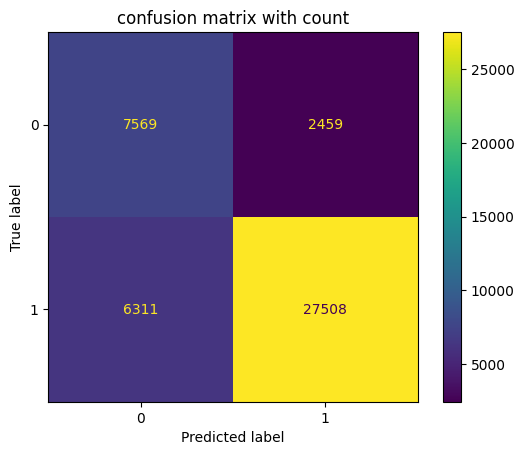

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR_best_pipeline, X_test, y_test)
plt.grid(False)
plt.title('confusion matrix with count')

In [17]:
# visualization
labels = ['Non-5-stars', '5-stars', 'Non-5-stars', '5-stars']
confusion_df = pd.DataFrame(conf_matrix, index=labels[:2], columns=labels[2:])
# Plot the confusion matrix using heatmap
fig = px.imshow(conf_matrix, 
                labels=dict(x="Predicted", y="Actual", color="Count"), 
                x=confusion_df.columns, 
                y=confusion_df.index,
                color_continuous_scale='Blues')
fig.update_layout(title_text='Confusion Matrix w/o showing count', title_x=0.5)
fig.show()

In [18]:
# Plot confusion matrix
fig = ff.create_annotated_heatmap(
    z=conf_matrix, 
    x=["Predicted Non-5-stars", "Predicted 5-stars"], 
    y=["Actual Non-5-stars", "Actual 5-stars"],
    annotation_text=conf_matrix.round(2).astype(str), 
    showscale=True
)
fig.update_layout(
    title='Confusion Matrix of Final model', 
    xaxis=dict(title='Predicted'), 
    yaxis=dict(title='True')
)
fig.show()
fig.write_html('final_model_cm.html', include_plotlyjs='cdn')

In [19]:
LR_results_df = pd.DataFrame(grid_search.cv_results_)
LR_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,40.383444,2.100888,11.466749,0.724745,"LogisticRegression(C=1, class_weight='balanced...",0.1,"{'classifier': LogisticRegression(C=1, class_w...",0.797643,0.799191,0.798683,...,0.798658,0.000615,4,0.811123,0.810444,0.810827,0.811487,0.811254,0.811027,0.000361
1,45.418624,1.345888,10.339384,0.842400,"LogisticRegression(C=1, class_weight='balanced...",1,"{'classifier': LogisticRegression(C=1, class_w...",0.808938,0.809788,0.808439,...,0.809425,0.000862,1,0.850153,0.848480,0.848718,0.849481,0.849147,0.849196,0.000590
2,53.531412,4.077415,9.985006,0.531006,"LogisticRegression(C=1, class_weight='balanced...",5,"{'classifier': LogisticRegression(C=1, class_w...",0.806923,0.808699,0.806159,...,0.807210,0.001116,2,0.884055,0.883423,0.884237,0.884524,0.883419,0.883932,0.000443
3,59.234007,3.634119,8.849408,0.461842,"LogisticRegression(C=1, class_weight='balanced...",10,"{'classifier': LogisticRegression(C=1, class_w...",0.803944,0.806346,0.804461,...,0.805063,0.001229,3,0.899749,0.898876,0.899875,0.900216,0.899345,0.899612,0.000462
4,56.105986,6.187466,6.532545,0.082371,"LogisticRegression(C=1, class_weight='balanced...",50,"{'classifier': LogisticRegression(C=1, class_w...",0.791877,0.796685,0.794231,...,0.794508,0.001604,5,0.930175,0.929507,0.930332,0.930237,0.929867,0.930024,0.000302


### Other Models Explored

In [20]:
### Gridsearch parameters for RF

## Random Forest: plan to tune max_depth and n_estimators, because they control
## the depth of each tree and the number of trees in the forest respectively.
param_grid_RF = {
    'classifier': [RandomForestClassifier(n_jobs=-1)],
    'classifier__max_depth': [None, 10, 30],
    'classifier__n_estimators': [10, 100, 200],
}

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', None)
])

grid_search = GridSearchCV(
    pipeline, 
    param_grid_RF, 
    cv=5, 
    scoring='f1_weighted', 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=1
    )

### Main block for fitting the gridsearch
print("Fitting...")
grid_search.fit(X_train, y_train)
print("Done.\n")

RF_best_pipeline = grid_search.best_estimator_
RF_best_param = grid_search.best_params_
RF_train_acc, RF_test_acc = result(RF_best_pipeline)
RF_train_f1, RF_test_f1, RF_train_pred, RF_test_pred = calculate_f1_score(RF_best_pipeline)

Fitting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/leica/anaconda3/envs/dsc80/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Done.



In [21]:
# Print results for RF
print("Results for Random Forest")
print("Training F1 Score:", RF_train_f1)
print('Testing F1 Score:', RF_test_f1)
print("\nTraining Classification Report:\n", classification_report(y_train, RF_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, RF_test_pred))
print('Cross-Validated accuracy:', grid_search.best_score_)
print('Best hyperparameters:', RF_best_param)

Results for Random Forest
Training F1 Score: 0.9940058629716394
Testing F1 Score: 0.753439642448923

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     39645
           1       0.99      1.00      1.00    135739

    accuracy                           0.99    175384
   macro avg       1.00      0.99      0.99    175384
weighted avg       0.99      0.99      0.99    175384


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.23      0.33     10028
           1       0.81      0.96      0.88     33819

    accuracy                           0.79     43847
   macro avg       0.72      0.59      0.61     43847
weighted avg       0.77      0.79      0.75     43847

Cross-Validated accuracy: 0.7548529958305067
Best hyperparameters: {'classifier': RandomForestClassifier(n_estimators=10, n_jobs=-1), 'classifier__max_depth': None, 'classifier__n

In [22]:
### Gridsearch parameters for DT

## Decision Tree: plan to tune max_depth and min_samples_split, because they could
## contro model's complexity and improve generalizations to avoid overfitting.
param_grid_DT = {
    'classifier': [DecisionTreeClassifier()],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]  
}

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', None)
])

grid_search = GridSearchCV(
    pipeline, 
    param_grid_DT, 
    cv=5, 
    scoring='f1_weighted', 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=1
)

### Main block for fitting the gridsearch
print("Fitting...")
grid_search.fit(X_train, y_train)
print("Done.\n")

DT_best_pipeline = grid_search.best_estimator_
DT_best_param = grid_search.best_params_
DT_train_f1, DT_test_f1, DT_train_pred, DT_test_pred = calculate_f1_score(DT_best_pipeline)

Fitting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done.



In [23]:
# Print results of DT
print("Results for Decision Tree")
print("Training F1 Score:", DT_train_f1)
print('Testing F1 Score:', DT_test_f1)
print("\nTraining Classification Report:\n", classification_report(y_train, DT_train_pred))
print("\nTesting Classification Report:\n", classification_report(y_test, DT_test_pred))
print('Cross-Validated accuracy:', grid_search.best_score_)
print('Best hyperparameters:', DT_best_param)

Results for Decision Tree
Training F1 Score: 0.7901795829950458
Testing F1 Score: 0.7672318514530839

Training Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.34      0.45     39645
           1       0.83      0.95      0.89    135739

    accuracy                           0.81    175384
   macro avg       0.75      0.65      0.67    175384
weighted avg       0.80      0.81      0.79    175384


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.30      0.40     10028
           1       0.82      0.94      0.88     33819

    accuracy                           0.79     43847
   macro avg       0.71      0.62      0.64     43847
weighted avg       0.77      0.79      0.77     43847

Cross-Validated accuracy: 0.7618444331297837
Best hyperparameters: {'classifier': DecisionTreeClassifier(max_depth=10), 'classifier__max_depth': 10, 'classifier__min_samples_spli

### Fairness Analysis

#### Permutation test: does our final model perform worse for individuals who have longer preparing minutes (more than median time) than it does for individuals who have shorter preparing minutes (less than median time)?
- Two groups in this case:
  - Individuals who have longer preparing minutes (more than median time)
  - Individuals who have shorter preparing minutes (less than median time)
- Null Hypothesis: Our final model is fair. Its f1-score for individuals who have longer preparing minutes and who have shorter preparing minutes are roughly the same, and any differences are due to random chance.
- Alternative Hypothesis: Our final model is unfair. Its f1-score for individuals who have longer preparing minutes is lower than its f1-score for individuals who have shorter preparing minutes.
- Test Statistic: Difference in f1-score between individuals who have longer preparing minutes and individuals who have shorter preparing minutes.
- Significance Level: a = 0.05
  - The significance level is a good choice because it is a common significance level that is used in hypothesis testing.

In [24]:
# binarizing the `minutes` column, longer => 1, shorter => 0
threshold = X_test['minutes'].median()
X_test['minute_group'] = X_test['minutes'].apply(lambda x: 1 if x >= threshold else 0)

In [25]:
# Test statistic
def f1_diff(label, group_labels, predictions):
    f1_x = f1_score(label[group_labels == 1], predictions[group_labels == 1])
    f1_y = f1_score(label[group_labels == 0], predictions[group_labels == 0])
    return f1_x - f1_y # longer - shorter

In [26]:
# observed difference
predictions = LR_best_pipeline.predict(X_test)
observed_diff = f1_diff(y_test, X_test['minute_group'], predictions)
observed_diff

-0.0030401952374990993

In [27]:
# permutation test
n_permutations = 10000
differences = []

for _ in range(n_permutations):
    X_test['shuffled'] = np.random.permutation(X_test['minute_group'])
    test_stat = f1_diff(y_test, X_test['shuffled'], predictions)
    differences.append(test_stat)

# if (longer_f1 - shorter_f1) <= observed_difference 
p_value = np.sum(differences <= observed_diff) / n_permutations
print("P-value:", p_value)

P-value: 0.1517


In [28]:
# visualization
fig = px.histogram(
    pd.DataFrame(differences), x=0, nbins=100, histnorm='probability', 
    title='Empirical Distrib. Difference in F1 Score (Longer - Shorter')
fig.add_vline(
    x=observed_diff, 
    line_color='red', 
    annotation=dict(x=observed_diff, text=f'Observed Statistic = {observed_diff:.3f}'), 
    annotation_font_color='red')
fig.write_html('fairness_analysis.html', include_plotlyjs='cdn')

In [29]:
## Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Fail to reject the null hypothesis.
